# How did We Find the Jumps at Regular Interval in Regressions?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

## Polynomial Regression 

#### Step 1 : Read files into dataframes

In [2]:
intraday_data = pd.read_csv('../fandi_intraday_data.csv')
daily_data = pd.read_csv('../fandi_daily.csv', parse_dates=['DATE'])

In [3]:
intraday_data['datetime'] = intraday_data['date'] + ' ' + intraday_data['time']
intraday_data['datetime'] = pd.to_datetime(intraday_data['datetime'])
intraday_data['date'] = pd.to_datetime(intraday_data['date'])

intraday_data['symbol'] = intraday_data['sym_root'] + intraday_data['sym_suffix']
intraday_data.loc[intraday_data['sym_suffix'].isnull(), 'symbol'] = intraday_data['sym_root']

sym_vol = {}

intra = intraday_data.loc[intraday_data['symbol'] == 'GOOGL']
daily = daily_data.loc[daily_data['symbol'] == 'GOOGL']
df = intra.merge(daily[['DATE', 'symbol', 'total_vol_m']], how='left', left_on=['date', 'symbol'], right_on = ['DATE', 'symbol'])
df.index = pd.DatetimeIndex(df['datetime'])
df.drop(columns=['DATE','datetime'], inplace=True)
df = df.between_time('09:30:00', '16:00:00')
df['%_vol'] = df['size']/df['total_vol_m']
sym_vol['GOOGL'] = df

#### Step 2 : Rolling for 180 days and Get the Percentage of Changes in Volumes 

In [4]:
def generate_u_curve(data):
    '''Generate u_curve based on 180 day average intraday volume'''

    # groupby time to calculate 180-day rolling average volume
    df = data.groupby(data.index.time)['%_vol'].rolling(180).mean()

    # ungroup, then sort df by date and time
    df = df.reset_index()
    df.rename(columns={'level_0': 'time', '%_vol': 'avg_%_vol'}, inplace=True)
    df['date'] = df['datetime'].dt.date
    df = df.sort_values(['date', 'time'], ascending=(True, True)).set_index(['date', 'time'])
    df.drop(columns=['datetime'], inplace=True)

    # convert date from row index to column index
    df = df.unstack().transpose()
    df.index = df.index.droplevel(0)

    return df

In [5]:
df = generate_u_curve(df)
df = df.dropna(axis=1)

In [6]:
new_data = df.stack().reset_index(-1, drop=True)

### Step 3: generate intra-day in minutes

In [1]:
#### we noticed the dataframe is 388 * 391 in shape which represents the number of minute per day
lst = []
for j in range(391):
    res = []
    for n in range(388):
        res.append(j)
    lst.extend(res)

In [8]:
x = np.array(lst)
y = new_data.values

In [9]:
def pick_window (x_value, y_value, win_in_mins, tail):
    '''
    pick up a specific window along the day and exclude the first and last 5 minutes
    '''
    mins = win_in_mins + 2
    if tail is False:
        y_i = y_value[388:388*mins]
        x_i = x_value[388:388*mins]
    else:
        y_i = y_value[-388*(mins+5):-388*5]
        x_i = x_value[-388*(mins+5):-388*5]
    return x_i, y_i

In [10]:
def find_poly (x_value, y_value, d):
    '''
    fit the x, y values and d represents the degree of the polynomial regressions
    '''
    x_value = x_value.reshape(-1,1)
    poly = PolynomialFeatures(degree=d)
    x_poly = poly.fit_transform(x_value)
    poly.fit(x_poly, y_value)
    linreg = LinearRegression()
    linreg.fit(x_poly, y_value)
    y_i_pred = linreg.predict(x_poly)
    return y_i_pred

### Opening - 15mins, degree = 3,4,5

In [39]:
x_15, y_15 = pick_window(x, y, 15, False)

In [40]:
y_3_pred = find_poly(x_15, y_15, 3)
y_4_pred = find_poly(x_15, y_15, 4)
y_5_pred = find_poly(x_15, y_15, 5)

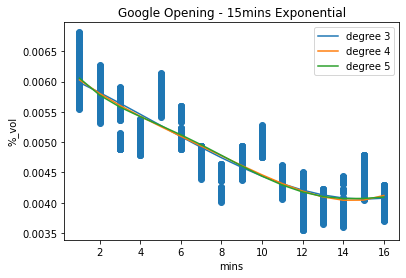

In [41]:
plt.scatter(x_15, y_15)
plt.plot(x_15,y_3_pred, label='degree 3')
plt.plot(x_15,y_4_pred, label='degree 4')
plt.plot(x_15,y_5_pred, label='degree 5')
plt.xlabel('mins')
plt.ylabel('%_vol')
plt.title('Google Opening - 15mins Exponential')
plt.legend()
plt.show()

### Opening - 60mins, degree = 3,4,5

In [42]:
x_60, y_60 = pick_window(x, y, 60, False)

In [43]:
y_3_pred = find_poly(x_60, y_60, 3)
y_4_pred = find_poly(x_60, y_60, 4)
y_5_pred = find_poly(x_60, y_60, 5)

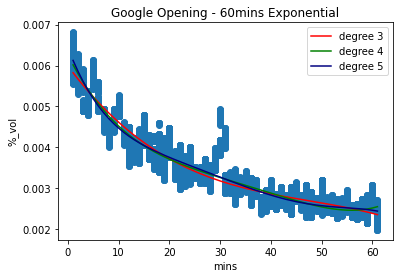

In [44]:
plt.scatter(x_60, y_60)
plt.plot(x_60,y_3_pred, label='degree 3',color='red')
plt.plot(x_60,y_4_pred, label='degree 4', color='green')
plt.plot(x_60,y_5_pred, label='degree 5', color='navy')
plt.xlabel('mins')
plt.ylabel('%_vol')
plt.title('Google Opening - 60mins Exponential')
plt.legend()
plt.show()


### Closing - 60mins (exclude last 5 mins), degree = 3,4,5

In [45]:
x_60, y_60 = pick_window(x, y, 60, True)

In [46]:
y_3_pred = find_poly(x_60, y_60, 3)
y_4_pred = find_poly(x_60, y_60, 4)
y_5_pred = find_poly(x_60, y_60, 5)

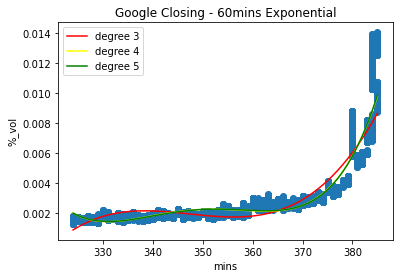

In [47]:
plt.scatter(x_60, y_60)
plt.plot(x_60,y_3_pred, label='degree 3',color='red')
plt.plot(x_60,y_4_pred, label='degree 4', color='yellow')
plt.plot(x_60,y_5_pred, label='degree 5', color='green')
plt.xlabel('mins')
plt.ylabel('%_vol')
plt.title('Google Closing - 60mins Exponential')
plt.legend()
plt.show()

### Closing - 30mins (exclude last 5 mins), degree = 3,4,5

In [55]:
x_30, y_30 = pick_window(x, y, 30, True)

In [56]:
y_3_pred = find_poly(x_30, y_30, 3)
y_4_pred = find_poly(x_30, y_30, 4)
y_5_pred = find_poly(x_30, y_30, 5)

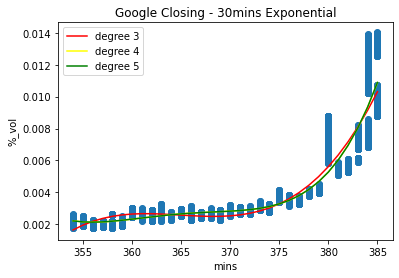

In [57]:
plt.scatter(x_30, y_30)
plt.plot(x_30,y_3_pred, label='degree 3',color='red')
plt.plot(x_30,y_4_pred, label='degree 4', color='yellow')
plt.plot(x_30,y_5_pred, label='degree 5', color='green')
plt.xlabel('mins')
plt.ylabel('%_vol')
plt.title('Google Closing - 30mins Exponential')
plt.legend()
plt.show()

### Closing - 15mins (exclude last 5 mins), degree = 3,4,5

In [52]:
x_15, y_15 = pick_window(x, y, 15, True)

In [53]:
y_3_pred = find_poly(x_15, y_15, 3)
y_4_pred = find_poly(x_15, y_15, 4)
y_5_pred = find_poly(x_15, y_15, 5)

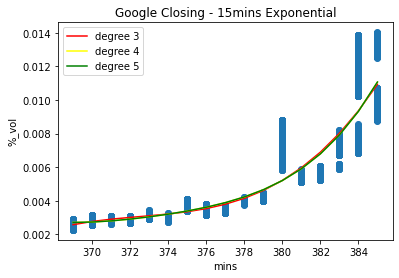

In [54]:
plt.scatter(x_15, y_15)
plt.plot(x_15,y_3_pred, label='degree 3',color='red')
plt.plot(x_15,y_4_pred, label='degree 4', color='yellow')
plt.plot(x_15,y_5_pred, label='degree 5', color='green')
plt.xlabel('mins')
plt.ylabel('%_vol')
plt.title('Google Closing - 15mins Exponential')
plt.legend()
plt.show()

## Exponential Regression 

In [58]:
import scipy.optimize as opt

In [59]:
def expo_funct (x,a,b,c):
    return a * np.exp(b * x) + c

In [72]:
def exponential_regression (x_data, y_data):
    popt, pcov = opt.curve_fit(expo_funct, x_data, y_data, p0 = (-1, 0.01, 1),maxfev=10000)
    print(popt)
    puntos = plt.scatter(x_data, y_data, label = "data")
    curva_regresion = plt.plot(x_data, expo_funct(x_data, *popt), color='red', linewidth = 2, label = "fit: {:.3f}, {:.3f}, {:.3f}".format(*popt))
    plt.xlabel('mins')
    plt.ylabel('%_vol')
    plt.title('Google Opening - 10mins Exponential')
    plt.legend()
    plt.show()
    return expo_funct(x_data, *popt)

### Closing - 60mins (exclude last 5 mins)

In [62]:
x_60, y_60 = pick_window(x, y, 60, True)

[9.30672475e-33 1.79251556e-01 1.94237444e-03]


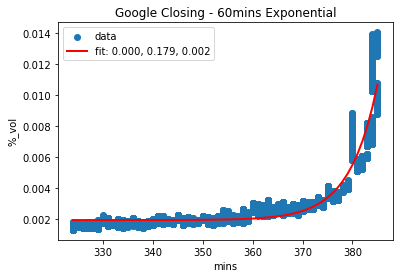

array([0.00194253, 0.00194253, 0.00194253, ..., 0.01065727, 0.01065727,
       0.01065727])

In [63]:
exponential_regression(x_60, y_60)

### Closing - 30mins (exclude last 5 mins)

In [64]:
x_30, y_30 = pick_window(x, y, 30, True)

[6.59952996e-39 2.16006537e-01 2.34713122e-03]


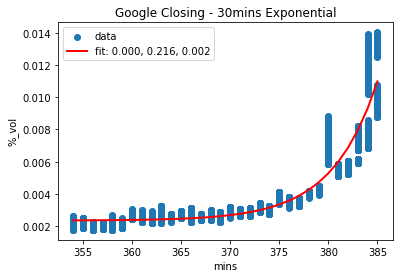

array([0.00235781, 0.00235781, 0.00235781, ..., 0.01098756, 0.01098756,
       0.01098756])

In [66]:
exponential_regression(x_30, y_30)

### Opening 60 mins

[-1.60465131e+01  3.14882702e-06  1.60515429e+01]


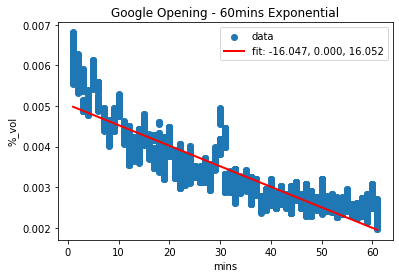

array([0.00497937, 0.00497937, 0.00497937, ..., 0.00194741, 0.00194741,
       0.00194741])

In [69]:
x_60, y_60 = pick_window(x, y, 60, False)
exponential_regression(x_60, y_60)

### Opening 30 mins

[-8.84756696e+00  8.97228943e-06  8.85305478e+00]


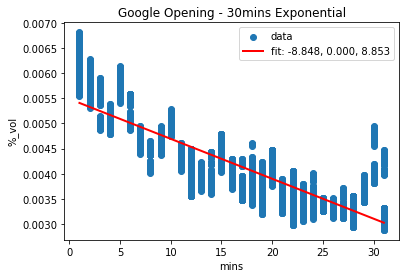

array([0.00540844, 0.00540844, 0.00540844, ..., 0.00302661, 0.00302661,
       0.00302661])

In [71]:
x_30, y_30 = pick_window(x, y, 30, False)
exponential_regression(x_30, y_30)

### Opening 10 mins

[-2.34999171e+00  6.64074919e-05  2.35607057e+00]


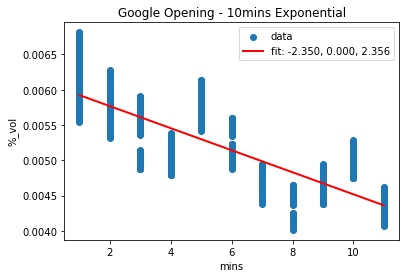

array([0.0059228, 0.0059228, 0.0059228, ..., 0.0043616, 0.0043616,
       0.0043616])

In [73]:
x_10, y_10 = pick_window(x, y, 10, False)
exponential_regression(x_10, y_10)